# Homework 3 - Improving the Pipeline 

CAPP 30235 Machine Learning for Public Policy

Jonathan Tan

May 2, 2019

# Part 1: Coding Assignment

Since I use most of the new functions prompted below in my analysis of the DonorsChoose data, I'll just briefly explain in this section which new functions I wrote and what they do.

### 1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TA. if something critical was pointed out in the feedback, you need to fix it. You'll get the last homework back by ends of thursday so you'll still have time before this one is due to address those comments.

I received no feedback from my last assignment, so I have skipped this step.

### 2. Add more classifiers to the pipeline. It should at least have Logistic Regression, K­Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

#### 2.1 `train_classifier()`

`train_classifier()` takes 2 pandas DataFrames (features and labels of training data) and the name of a classifier to fit. It optionally takes a nested dictionary of hyperparameters to use for each. (For this notebook, these parameters can be changed in the `pipeline_config.py` file.) It returns a trained classifier object.

### 3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects. The labs should be helpful here.

Results of experimenting with different parameters (e.g. penalty and C for LogisticRegression, n_estimators for Boosting) can be seen in the parameter dictionary in the `pipeline_config.py` file. I looped over several ranges of reasonable values for each parameter and selected the configuration producing the largest AUC-ROC. These will be the default parameters used in the DonorsChoose analysis part of this assignment.

### 4. Add additional evaluation metrics that we've covered in class to the pipeline (accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves).

#### 4.1 `validate_classifier()`

`validate_classifier()` takes 2 dataframes (features and labels for test data) and a pre-trained classifier object as inputs, calculates several evaluation metrics (accuracy, precision, recall, F1, etc.) and returns a dictionary of those metrics.

### 5. Create temporal validation function in your pipeline that can create training and test sets over time. You can choose the length of these splits based on analyzing the data. For example, the test sets could be six months long and the training sets could be all the data before each test set.

#### 5.1 `split_data_temporal()`

`split_data_temporal()` takes a pandas DataFrame and specified label/date column names as inputs, then splits the dataframe on the specified timeframe. The default test set duration is the most recent 1 year of data. It returns two dataframes and two series in order:
 1. training features
 2. test features
 3. training labels
 4. test labels


# Part 2: Analysis

## 0. Setup

In [138]:
# Setup autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale

# Import pipeline library, hardcoded config file values
import pipeline_library as library
import pipeline_config as config

## 1. Read data

In [140]:
df = library.read_data(config.DATA_PATH)
print(df.shape)
df.head()

(124976, 26)


,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [141]:
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded'],
      dtype='object')

## 2. Explore data

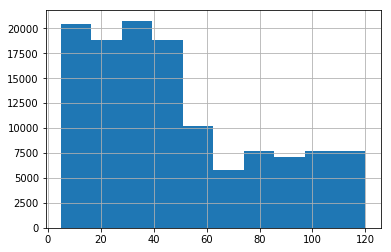

In [142]:
# Histogram of number of days to being fully funded
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%m/%d/%y')
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'], format='%m/%d/%y')
df['days_to_funded'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['days_to_funded'].hist()

In [143]:
# What percentage of projects are funded within 60 days?
len(df.loc[df['days_to_funded'] <= 60]) / len(df)

0.7118646780181795

In [145]:
numeric_features = ['total_price_including_optional_support', 'students_reached']

library.describe_data(df, varlist=numeric_features)

,total_price_including_optional_support,students_reached
count,124976.000000,124917.000000
mean,654.011811,95.445760
std,1098.015854,163.481912
min,92.000000,1.000000
25%,345.810000,23.000000
50%,510.500000,30.000000
75%,752.960000,100.000000
max,164382.840000,12143.000000


## 3. Pre-process data / Generate features/predictors

To avoid pre-processing data that will be omitted from the training data, below I pre-select the features I want to use and focus on cleaning those.

Data cleaning steps:
1. Select features to be used in final model(s)
2. Define label: `funded_in_60_days`
3. Clean missing data
4. Normalize numeric data
5. Make binary data into true binary
6. Make categorical data into dummies

### 3.1 Select features for the final model(s)

Here, I've excluded extraneous features like the ID columns and lat/long data, as well as geographical features like `school_district` and `school_city` that should be highly collinear with the remaining `school_county` and `school_state` features.

In [146]:
selected_features = ['school_state', 'school_metro', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_area', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded']

df = df[selected_features]

### 3.2 Define label: `funded_in_60_days`

In [147]:
df['fully_funded_in_60_days'] = \
    (df['datefullyfunded'] - df['date_posted'] <= pd.to_timedelta(60, unit='days')).astype('int')

df[['date_posted', 'datefullyfunded', 'fully_funded_in_60_days']].head()

,date_posted,datefullyfunded,fully_funded_in_60_days
0,2013-04-14,2013-05-02,1
1,2012-04-07,2012-04-18,1
2,2012-01-30,2012-04-15,0
3,2012-10-11,2012-12-05,1
4,2013-01-08,2013-03-25,0


In [148]:
df = df.drop(labels=['datefullyfunded'], axis=1)

### 3.3 Clean missing data

First, let's see which columns are missing data.

In [149]:
df.isnull().sum(axis=0)

school_state                                  0
school_metro                              15224
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_area                           15
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                                   0
fully_funded_in_60_days                       0
dtype: int64

For many of these, mostly categorical features, we have no reliable way of filling in the missing data with useful placeholders. One way to handle it is to leave missing values as they are, and when converting categorical data to a series of dummy features later, these will have a specific binary column. 

For the numeric column with missing data - students reached - we will fill it in with the mean value of the feature.

In [150]:
# school_metro - 15224 missing, categorical - leave as is
# primary_focus_area - 15 missing, categorical - leave as is
# secondary_focus_area - 40556 missing, categorical - leave as is
# resource_type - 17 missing, categorical - leave as is
# grade_level - 3 missing, leave as is

# students_reached - 59 missing, integer, fill with mean
df['students_reached'] = library.fill_missing(df['students_reached'])

### 3.4 Rescale/standardize numeric data

In [151]:
for i in numeric_features:
    df[i] = scale(df[i])
    
df[numeric_features].describe()

,total_price_including_optional_support,students_reached
count,1.249760e+05,1.249760e+05
mean,-5.330760e-17,8.715237e-17
std,1.000004e+00,1.000004e+00
min,-5.118451e-01,-5.778526e-01
25%,-2.806909e-01,-4.432488e-01
50%,-1.307016e-01,-3.943019e-01
75%,9.011581e-02,2.786445e-02
max,1.491140e+02,7.371120e+01


### 3.5 Make binary data into true binary format

The `school_charter`, `school_magnet` and `eligible_double_your_impact_match` features are also binary variables coded as string variables ("t" or "f"), so we'll convert them to a true binary variable.

In [152]:
binary_features = ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']

for i in binary_features:
    df[i] = np.where(df[i] == 't', 1, 0)

df[binary_features].head()

,school_charter,school_magnet,eligible_double_your_impact_match
0,0,0,0
1,0,0,1
2,0,0,0
3,0,1,0
4,0,0,0


### 3.6 Make categorical data into dummies

In [153]:
categorical_features = ['school_state', 'school_metro', 'teacher_prefix', \
                        'resource_type', 'primary_focus_area', 'secondary_focus_area', \
                        'poverty_level', 'grade_level']

for i in categorical_features:
    df = library.make_dummy_vars(df, i)

df.head()

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,fully_funded_in_60_days,school_state_AK,school_state_AL,school_state_AR,...,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
0,0,0,0.769207,-0.394302,0,2013-04-14,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,-0.338377,-0.412657,1,2012-04-07,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0.326379,-0.241343,0,2012-01-30,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0,1,-0.435953,-0.443249,0,2012-10-11,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,2.674925,0.333782,0,2013-01-08,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [154]:
df.shape

(124976, 93)

In [155]:
df.columns

Index(['school_charter', 'school_magnet',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted',
       'fully_funded_in_60_days', 'school_state_AK', 'school_state_AL',
       'school_state_AR', 'school_state_AZ', 'school_state_CA',
       'school_state_CO', 'school_state_CT', 'school_state_DC',
       'school_state_DE', 'school_state_FL', 'school_state_GA',
       'school_state_HI', 'school_state_IA', 'school_state_ID',
       'school_state_IL', 'school_state_IN', 'school_state_KS',
       'school_state_KY', 'school_state_LA', 'school_state_MA',
       'school_state_MD', 'school_state_ME', 'school_state_MI',
       'school_state_MN', 'school_state_MO', 'school_state_MS',
       'school_state_MT', 'school_state_NC', 'school_state_ND',
       'school_state_NE', 'school_state_NH', 'school_state_NJ',
       'school_state_NM', 'school_state_NV', 'school_state_NY',
       'school_state_OH', 'school_state_OK', 'school_s

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 93 columns):
school_charter                              124976 non-null int64
school_magnet                               124976 non-null int64
total_price_including_optional_support      124976 non-null float64
students_reached                            124976 non-null float64
eligible_double_your_impact_match           124976 non-null int64
date_posted                                 124976 non-null datetime64[ns]
fully_funded_in_60_days                     124976 non-null int64
school_state_AK                             124976 non-null int64
school_state_AL                             124976 non-null int64
school_state_AR                             124976 non-null int64
school_state_AZ                             124976 non-null int64
school_state_CA                             124976 non-null int64
school_state_CO                             124976 non-null int64
school_state_CT   

## 4. Build and evaluate classifiers

Model building and validation steps:
1. Split data into test and train temporal sets
2. Train series of classifiers on training data, then print evaluation metrics

### 4.1 Split data into test and train sets by time

In [157]:
# Get three different temporal test/train sets and append to list
test_train = []
TEST_DUR = 6
TEST_UNITS = 'M'
new_df = df.copy(deep=True)

while True:
    # split_data_temporal returns (x_train, x_test, y_train, y_test)
    data = library.split_data_temporal(new_df, label=config.LABEL, date_col='date_posted', \
                                       test_dur=TEST_DUR, test_units=TEST_UNITS)
    test_train.append(data)
    
    # if length of training set is shorter than length of test set, break
    train_length = data[0]['date_posted'].max() - data[0]['date_posted'].min()
    test_length = data[1]['date_posted'].max() - data[1]['date_posted'].min()
    
    if train_length <= test_length:
        break
    else:
        new_max = new_df['date_posted'].max() - pd.to_timedelta(TEST_DUR, TEST_UNITS)
        new_df = new_df.loc[new_df['date_posted'] < new_max]

In [158]:
# Make sure temporal splits worked correctly
# Each entry in list is a 4-tuple of (x_train, x_test, y_train, y_test)
# Drop date_posted field after validating

for i in range(len(test_train)):
    train_start = test_train[i][0]['date_posted'].min().date()
    train_end = test_train[i][0]['date_posted'].max().date()
    train_dur = train_end - train_start
    test_start = test_train[i][1]['date_posted'].min().date()
    test_end = test_train[i][1]['date_posted'].max().date()
    test_dur = test_end - test_start
    print(f'TRAINING SET {i + 1}: start: {train_start}, end: {train_end}, dur: {train_dur}')
    print(f'TEST SET {i + 1}: start: {test_start}, end: {test_end}, dur: {test_dur}')
    print('')

TRAINING SET 1: start: 2012-01-01, end: 2013-07-01, dur: 547 days, 0:00:00
TEST SET 1: start: 2013-07-02, end: 2013-12-31, dur: 182 days, 0:00:00

TRAINING SET 2: start: 2012-01-01, end: 2012-12-30, dur: 364 days, 0:00:00
TEST SET 2: start: 2012-12-31, end: 2013-07-01, dur: 182 days, 0:00:00

TRAINING SET 3: start: 2012-01-01, end: 2012-06-30, dur: 181 days, 0:00:00
TEST SET 3: start: 2012-07-01, end: 2012-12-30, dur: 182 days, 0:00:00



### 4.2 Train and evaluate classifiers

In [159]:
# Set test/train splits, classifiers, precision-recall thresholds to loop over
# TODO - WHY DOES KNN BREAK PREDICT_PROBA?
classifiers = ['LogisticRegression', 'DecisionTreeClassifier',
               'LinearSVC', 'RandomForestClassifier', 'AdaBoostClassifier', 
               'BaggingClassifier']
pr_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
results_df = pd.DataFrame()

# Loop
for i in classifiers:
    for j in test_train:
            # select correct test-train split
            x_train, x_test, y_train, y_test = j

            test_start = str(x_test['date_posted'].min().date())
            test_end = str(x_test['date_posted'].max().date())

            # drop date cols before training
            x_train = x_train.drop(labels=['date_posted'], axis=1)
            x_test = x_test.drop(labels=['date_posted'], axis=1)

            # train model
            trained = library.train_classifier(x_train, y_train, 
                                               method=i, 
                                               param_dict=config.MODEL_PARAMS)

            # evalute results
            results_dict = library.validate_classifier(x_test, y_test, trained,
                                                       label_threshold=config.CLASS_THRESHOLD,
                                                       pr_threshold=pr_thresholds)
            results_dict['threshold'] = config.CLASS_THRESHOLD
            results_dict['test-start'] = test_start
            results_dict['test-end'] = test_end

            # save to dict
            results_df = results_df.append(results_dict, ignore_index=True)

Training LogisticRegression with params {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear', 'random_state': 0}.
Validating LogisticRegression
Training LogisticRegression with params {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear', 'random_state': 0}.
Validating LogisticRegression
Training LogisticRegression with params {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear', 'random_state': 0}.
Validating LogisticRegression
Training DecisionTreeClassifier with params {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'random_state': 0}.
Validating DecisionTreeClassifier
Training DecisionTreeClassifier with params {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'random_state': 0}.
Validating DecisionTreeClassifier
Training DecisionTreeClassifier with params {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'random_state': 0}.
Validating DecisionTreeClassifier
Training LinearSVC with params {'penalty': 'l2', 'C': 1.0, 'max_iter': 1000, 'random_sta

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Validating LinearSVC
Training LinearSVC with params {'penalty': 'l2', 'C': 1.0, 'max_iter': 1000, 'random_state': 0}.


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Validating LinearSVC
Training LinearSVC with params {'penalty': 'l2', 'C': 1.0, 'max_iter': 1000, 'random_state': 0}.


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validating LinearSVC
Training RandomForestClassifier with params {'criterion': 'entropy', 'max_features': 'auto', 'random_state': 0}.
Validating RandomForestClassifier
Training RandomForestClassifier with params {'criterion': 'entropy', 'max_features': 'auto', 'random_state': 0}.


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validating RandomForestClassifier
Training RandomForestClassifier with params {'criterion': 'entropy', 'max_features': 'auto', 'random_state': 0}.


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validating RandomForestClassifier
Training AdaBoostClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating AdaBoostClassifier
Training AdaBoostClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating AdaBoostClassifier
Training AdaBoostClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating AdaBoostClassifier
Training BaggingClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating BaggingClassifier
Training BaggingClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating BaggingClassifier
Training BaggingClassifier with params {'n_estimators': 10, 'random_state': 0}.
Validating BaggingClassifier


In [160]:
results_df = results_df.set_index(['classifier', 'threshold', 'test-start', 'test-end'])
results_df.to_excel("output/results.xlsx")
results_df

accuracy   auc-roc  \
classifier             threshold test-start test-end                         
LogisticRegression     0.53      2013-07-02 2013-12-31  0.711772  0.655238   
                                 2012-12-31 2013-07-01  0.691834  0.647798   
                                 2012-07-01 2012-12-30  0.720332  0.630703   
DecisionTreeClassifier 0.53      2013-07-02 2013-12-31  0.715291  0.612613   
                                 2012-12-31 2013-07-01  0.684899  0.610808   
                                 2012-07-01 2012-12-30  0.731165  0.592765   
LinearSVC              0.53      2013-07-02 2013-12-31  0.713906  0.657643   
                                 2012-12-31 2013-07-01  0.687609  0.650177   
                                 2012-07-01 2012-12-30  0.732935  0.630828   
RandomForestClassifier 0.53      2013-07-02 2013-12-31  0.667840  0.634782   
                                 2012-12-31 2013-07-01  0.657803  0.620932   
                                 2012-07-01 2012-12-30  0.664887  0.614106   
AdaBoostClassifier     0.53      2013-07-02 2013-12-31  0.503190  0.663427   
                                 2012-12-31 2013-07-01  0.526499  0.666147   
                                 2012-07-01 2012-12-30  0.501510  0.648891   
BaggingClassifier      0.53      2013-07-02 2013-12-31  0.665501  0.636271   
                                 2012-12-31 2013-07-01  0.655507  0.621075   
                                 2012-07-01 2012-12-30  0.655091  0.614359   

                                                              f1  \
classifier             threshold test-start test-end               
LogisticRegression     0.53      2013-07-02 2013-12-31  0.823290   
                                 2012-12-31 2013-07-01  0.812066   
                                 2012-07-01 2012-12-30  0.828669   
DecisionTreeClassifier 0.53      2013-07-02 2013-12-31  0.833457   
                                 2012-12-31 2013-07-01  0.810778   
                                 2012-07-01 2012-12-30  0.842993   
LinearSVC              0.53      2013-07-02 2013-12-31  0.829132   
                                 2012-12-31 2013-07-01  0.812369   
                                 2012-07-01 2012-12-30  0.841317   
RandomForestClassifier 0.53      2013-07-02 2013-12-31  0.772812   
                                 2012-12-31 2013-07-01  0.767396   
                                 2012-07-01 2012-12-30  0.772930   
AdaBoostClassifier     0.53      2013-07-02 2013-12-31  0.508579   
                                 2012-12-31 2013-07-01  0.522597   
                                 2012-07-01 2012-12-30  0.537329   
BaggingClassifier      0.53      2013-07-02 2013-12-31  0.768506   
                                 2012-12-31 2013-07-01  0.762679   
                                 2012-07-01 2012-12-30  0.761826   

                                                        precision_0.01  \
classifier             threshold test-start test-end                     
LogisticRegression     0.53      2013-07-02 2013-12-31        0.854545   
                                 2012-12-31 2013-07-01        0.899083   
                                 2012-07-01 2012-12-30        0.908537   
DecisionTreeClassifier 0.53      2013-07-02 2013-12-31        0.847727   
                                 2012-12-31 2013-07-01        0.876147   
                                 2012-07-01 2012-12-30        0.820122   
LinearSVC              0.53      2013-07-02 2013-12-31        0.920455   
                                 2012-12-31 2013-07-01        0.917431   
                                 2012-07-01 2012-12-30        0.908537   
RandomForestClassifier 0.53      2013-07-02 2013-12-31        0.870455   
                                 2012-12-31 2013-07-01        0.811927   
                                 2012-07-01 2012-12-30        0.853659   
AdaBoostClassifier     0.53      2013-07-02 2013-12-31        0.988636   
                        

# Part 3: Report

### 3.1 Compare the performance of the different classifiers. Which classifier does better on which metrics?

The models using logistic regression, decision trees, and support vector machines all seemed to perform comparably at overall accuracy. Depending on the length of time used for the training data, 71-73% of their predictions (of which projects would be funded within 60 days) were correct.

Interestingly enough, if considering instead the precision metric, the models using a boosted ensemble of logistic regression classifiers performed the best. Overall, 84-87% of the projects predicted to be fully funded within 60 days actually turned out to be so. When looking only at the top 1% of projects, ranked by likelihood of being fully funded in 60 days, 96-99% of them are correctly predicted.

Given that 71% of projects in the dataset are actually funded within 60 days, most of our measures of recall - the proportion of projects actually fully funded within 60 days that were  correctly predicted by the model - are irrelevant. Overall, here, models using decision trees performed the best, correctly identifying 97-99% of projects actually meeting the criterion.

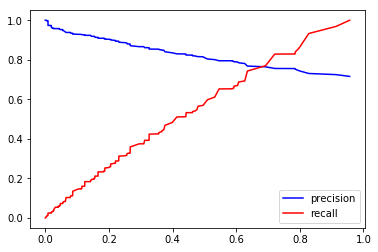

In [163]:
# Plot precision-recall curve for suggested model. Code adapted from Lab 4.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_curve

# Get 18-month training data
x_train, x_test, y_train, y_test = test_train[0]
x_train = x_train.drop(labels=['date_posted'], axis=1)
x_test = x_test.drop(labels=['date_posted'], axis=1)

# Train
boost = AdaBoostClassifier(n_estimators=10, random_state=0)
trained = boost.fit(x_train, y_train)
y_scores = boost.predict_proba(x_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
population = [sum(y_scores > threshold)/len(y_scores) for threshold in thresholds]

# Plot
p, = plt.plot(population, precision[:-1], color='b')
r, = plt.plot(population, recall[:-1], color='r')
plt.legend([p, r], ['precision', 'recall'])
plt.savefig('output/best_model_precision.png', format='png')

### 3.2 How do the results change over time?

For each classifier used, we trained models on training data over three different lengths: 6, 12, and 18 months prior to the 6 months of data used to test our models. For example, since we have data from Jan 1, 2012 to Dec 31, 2013, the longest training data used was from Jan 1, 2012 to June 30, 2013, with July 1, 2013 to Dec 1, 2013 forming the test set. 

In almost every case, models trained on 18 months of training data outperformed the other two variants. However, models trained on 6 months of training data outperformed those trained on 12 months of training data across almost every metric (accuracy, f1, precision at various thresholds). If looking only at the AUC-ROC - a measure of balance between true and false positive rates, called the area under the curve (AUC) for the receiver operating characteristics (ROC) curve - the expected order appears, where models trained on 18th months of data outperform those trained on 12 months of data, which themselves outperform those trained on 6 months of data.

### 3.3 What would be your recommendation to someone who's working on this model to identify 5% of posted projects to intervene with? Which model should they decide to go forward with and deploy?

As always, this depends on the specific intervention and its goal. Is it to maximize overall fundraising dollars? To maximize the number of projects that are successfuly funded? (Fortunately, since DonorsChoose stops fundraising for a project once the intended goal amount is met, these are functionally the same thing.)

But the question remains. Which 5% of projects do we want to intervene on? If selecting projects deemed *most* likely to be fully funded in 60 days, those would be the projects probably likely to be fully funded without intervention at all. In this case, DonorsChoose could use "exciting" projects like these as a source of marketing material, or target the donor pools to those projects for additional giving opportunities on other projects. If so, I would recommend using the **boosting ensemble model trained on 18 months of data**, which performed the best on precision at 5%. In other words, of the top 5% of projects it identified as likely to be fully funded in 60 days, 95% of them were actually so. 

If intervening on the 5% of projects *least* likely to be funded within 60 days, or perhaps projects that were unlikely to do so without a nudge or sorts, the potential intervention here could be additional fundraising support in the form of DonorsChoose staff coaching the teacher involved on how to better ask for donations from their networks. In this case, the metric of interest would be the precision at 50% (assuming projects that are 50% likely to be funded within 60 days are on that threshold), and the model that performs best on this metric is still the **boosting ensemble model trained on 18 months of data**.

Perhaps the metric we want to maximize is the number of students reached by the 5% of projects we will intervene on. The specific interventions here could be any of the actions already mentioned above. In this case, we would select the combination of projects where the *expected* number of students reached (calculated by the likelihood of being fully funded in 60 days, multiplied by the number of students reached by that project) is the largest possible. Without prior knowledge of how the number of students reached is distributed among projects, we would do best here to maximize overall precision. Fortunately, the model that does this is still the **boosting ensemble model trained on 18 months of data*.

There are other considerations that we have not explored here. The specific model we choose to inform our interventions can depend on a whole host of factors. Should projects in schools in low-income neighborhoods get priority? Should projects that ask for specific types of resources (e.g. stationery vs. computers) get priority? Should projects that are most cost-efficient, serving the largest number of children for the lowest per-child dollar amount, get priority? If we know more about the specific ways DonorsChoose might seek to use this model to identify projects, and the range of interventions available to them, we could provide more useful recommendations.